# The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:
- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)
  
We also have the following data for each star:
- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by Deepraj Baidya and was originally published on Kaggle.

It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
- are there any missing values?
- are there NaNs in the data?

Star classification is something that can be done based on rules depending on temperature and luminosity. We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

In [28]:
import urllib.request
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, precision_recall_curve
from IPython.display import display, Markdown

In [2]:
#Import data and visualization
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")
df_stars = pd.read_csv("stars.csv")
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


In [3]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


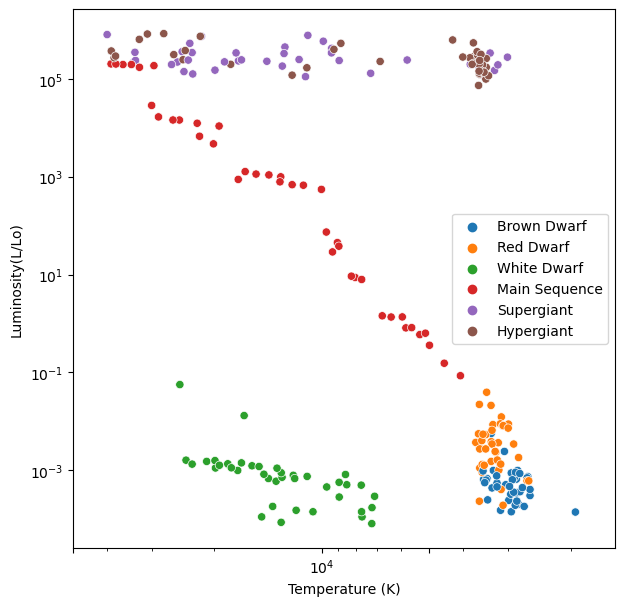

In [4]:
#HR diagram
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.
- Apply PCA to the dataset at your disposal (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two. This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.
  
This is actually a very important lesson in machine learning: Massaging your data before giving them to an algorithm can make things much much better.
- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is the usual machine-learning approach) standardize your data such that each dimension has mean=0 and variance=1.
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?

In [5]:
#First check if there are missing data or NaN
print(df_stars.isna().any().any())

False


Text(0, 0.5, 'Second Component')

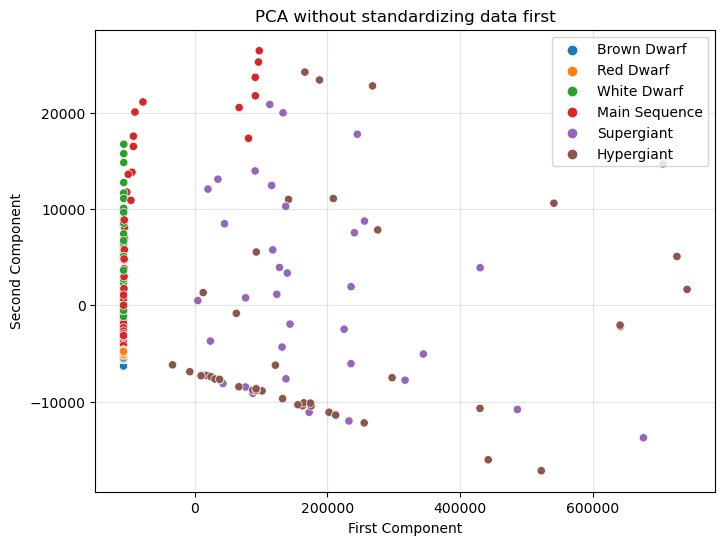

In [6]:
#PCA
#we need the data without the columns with labels
data_pd = df_stars.drop(columns=["Star color", "Star type", "Spectral Class"])
data = np.array(data_pd)
pca = PCA(n_components=2)  
projected_data = pca.fit_transform(data) #fit + dimensionality reduction on data

fig = plt.figure(figsize=(8,6))
sns.scatterplot(x = projected_data[:, 0], y = projected_data[:,1], hue=labels)
plt.grid(c='grey', alpha = 0.2)
plt.title('PCA without standardizing data first')
plt.xlabel('First Component')
plt.ylabel('Second Component')

As we expect, this is terrible. What happens if I rescale the data first?

Component 1 explains 60.4% of the variance (cumulative = 60.4)
Component 2 explains 23.5% of the variance (cumulative = 83.9)


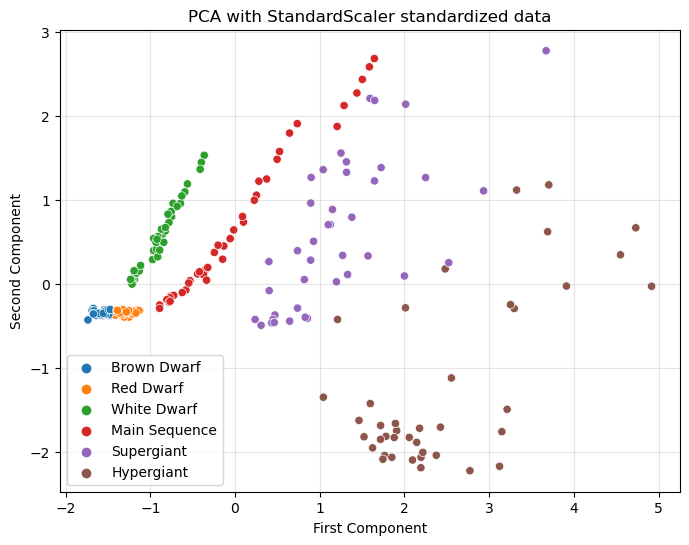

In [7]:
#Standardize data such that each dimension has mean=0 and variance=1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pd)

#Do again the PCA
pca2 = PCA(n_components=2) 
projected_stars2 = pca2.fit_transform(data_scaled)

fig2 = plt.figure(figsize=(8,6))
sns.scatterplot(x = projected_stars2[:, 0], y = projected_stars2[:,1], hue=labels)
plt.grid(c='grey', alpha = 0.2)
plt.title('PCA with StandardScaler standardized data')
plt.xlabel('First Component')
plt.ylabel('Second Component')

#Explain the variance
s = 0
for idx, r in enumerate(pca2.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f})")

Component 1 explains 63.8% of the variance (cumulative = 63.8)
Component 2 explains 21.4% of the variance (cumulative = 85.2)


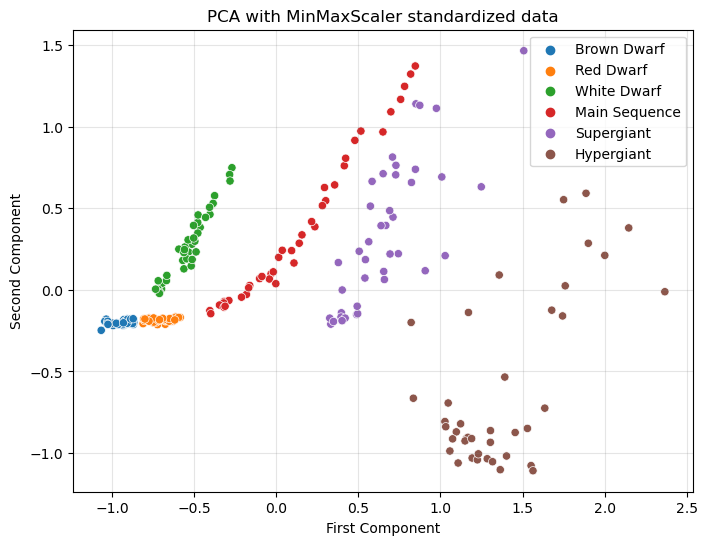

In [8]:
#Linear affine transformation such that each dimension goes between -1 and 1.
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled2 = pd.DataFrame(scaler.fit_transform(data_pd), columns=data_pd.columns)

#Do again the PCA
pca3 = PCA(n_components=2) 
projected_stars3 = pca3.fit_transform(data_scaled2)

fig3 = plt.figure(figsize=(8,6))
sns.scatterplot(x = projected_stars3[:, 0], y = projected_stars3[:,1], hue=labels)
plt.grid(c='grey', alpha = 0.2)
plt.title('PCA with MinMaxScaler standardized data')
plt.xlabel('First Component')
plt.ylabel('Second Component')

#Explain the variance
s = 0
for idx, r in enumerate(pca3.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f})")

Both the two methods give a similar results.

### PCA with four components for the second method of standardization

In [24]:
pca_4 = PCA(n_components=4) 
projected_stars_4 = pca_4.fit_transform(data_scaled2)

#Explain the variance
s = 0
for idx, r in enumerate(pca_4.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f})")

Component 1 explains 63.8% of the variance (cumulative = 63.8)
Component 2 explains 21.4% of the variance (cumulative = 85.2)
Component 3 explains 8.4% of the variance (cumulative = 93.6)
Component 4 explains 6.4% of the variance (cumulative = 100.0)


## Part 2
- Now run a supervised classification algorithm on this dataset. 
- Can you predict the stellar type? How well? Careful with overfitting of course.

## Split data into train and test set

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(projected_stars2, labels, test_size=0.25, random_state=0)

## Random forest 

We use only the train set to do the cross validation so that the test set must be completely unknown data.

In [19]:
forest = RandomForestClassifier(criterion='entropy', n_jobs=-1)
drange = np.arange(1, 16)  

grid = GridSearchCV(forest, param_grid={'max_depth': drange}, cv=5) 
grid.fit(X_train, Y_train)

best_forest = grid.best_params_['max_depth']
print("best parameter choice:", best_forest)

best parameter choice: 14


In [26]:
forest = RandomForestClassifier(n_estimators=200, max_depth=best_forest, criterion='entropy', n_jobs=-1)
forest.fit(X_train, Y_train)
Y_pred_test = forest.predict(X_test)
Y_pred_train = forest.predict(X_train)

accuracy_forest_test = accuracy_score(Y_test, Y_pred_test)
precision_forest_test = precision_score(Y_test, Y_pred_test, average='weighted')
completeness_forest_test = recall_score(Y_test, Y_pred_test, average='weighted')
contamination_forest_test = 1- precision_score(Y_test, Y_pred_test, average='weighted')
conf_matrix_test = confusion_matrix(Y_test, Y_pred_test)

accuracy_forest_train = accuracy_score(Y_train, Y_pred_train)
precision_forest_train = precision_score(Y_train, Y_pred_train, average='weighted')
completeness_forest_train = recall_score(Y_train, Y_pred_train, average='weighted')
contamination_forest_train = 1- precision_score(Y_train, Y_pred_train, average='weighted')
conf_matrix_train = confusion_matrix(Y_train, Y_pred_train)

In [30]:
data_train = {
    'Depth': [best_forest],
    'Accuracy': [accuracy_forest_train], 
    'Precision': [precision_forest_train],
    'Completeness':[completeness_forest_train], 
    'Contamination': [contamination_forest_train],
}
df_tr = pd.DataFrame(data_train)
df_tr = df_tr.round(2)
display(Markdown("### Results of Random forest on train dataset:"))
display(df_tr)
print('The confusion matrix for train set is:\n', conf_matrix_train)

data_test = {
    'Detph': [best_forest],
    'Accuracy': accuracy_forest_test, 
    'Precision': precision_forest_test,
    'Completeness':completeness_forest_test, 
    'Contamination': contamination_forest_test,
}
df_t_forest = pd.DataFrame(data_test)
df_t_forest = df_t_forest.round(2)
display(Markdown("### Results of Random Forest on test dataset:"))
display(df_t_forest)
print('The confusion matrix for test set is:\n', conf_matrix_test)

### Results of Random forest on train dataset:

,Depth,Accuracy,Precision,Completeness,Contamination
0,14,1.0,1.0,1.0,0.0


The confusion matrix for train set is:
 [[32  0  0  0  0  0]
 [ 0 29  0  0  0  0]
 [ 0  0 28  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 28  0]
 [ 0  0  0  0  0 33]]


### Results of Random Forest on test dataset:

,Detph,Accuracy,Precision,Completeness,Contamination
0,14,0.95,0.95,0.95,0.05


The confusion matrix for test set is:
 [[ 8  0  0  0  0  0]
 [ 0 10  0  0  1  0]
 [ 0  0 11  1  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  1  0 11  0]
 [ 0  0  0  0  0  7]]
